# Convolution

In [1]:
# DL framework
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

from datetime import datetime

# common packages
import numpy as np
import os # handling file i/o
import sys
import math
import time # timing epochs

# for ordered dict when building layer components
import collections

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import colors # making colors consistent
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar helper

# read image
from imageio import imread
# + data augmentation
from scipy import ndimage
from scipy import misc

# used for manually saving best params
import pickle

# for shuffling data batches
from sklearn.utils import shuffle

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# helper to create dirs if they don't already exist
def maybe_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} createed".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
    
# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Important Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.5.0-dev20171220
No GPU found


In [2]:
# `/output_images` will hold, you guessed it, output images
INPUT_DIR = "./dependencies"
OUTPUT_DIR = "./output_images"
maybe_create_dir(OUTPUT_DIR)

./output_images already exists


In [3]:
def implot(img, ax):
    im = ax.imshow(img.astype(np.uint8), interpolation="nearest")
    ax.set_axis_off()
    
# helper to plot images side-by-side, and save, if requested
def plot_side_by_side(image_a, image_b, SAVE_FIG_TO_OUTPUT=None):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))

    implot(image, ax1)
    implot(mask, ax2)

    plt.grid('off')
    plt.tight_layout()
    
    if SAVE_FIG_TO_OUTPUT:
        name_str = '{}.png'.format(SAVE_FIG_TO_OUTPUT)
        plt.savefig(os.path.join(OUTPUT_DIR, name_str), dpi=300)
        print(name_str + " saved to disk")
    
    plt.show()

def plot_single_image(image, SAVE_FIG_TO_OUTPUT=None):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10,10))
    implot(image, ax1)
    plt.grid('off')
    plt.tight_layout()
    if SAVE_FIG_TO_OUTPUT:
        name_str = '{}.png'.format(SAVE_FIG_TO_OUTPUT)
        plt.savefig(os.path.join(OUTPUT_DIR, name_str), dpi=300)
        print(name_str + " saved to disk")
    
    plt.show()

## Get image online to experiement with
1. visit the Google machine
2. search images, (select license type - `reuse w/modification`)
3. download -- I placed the image in the `./dependencies` directory

In [4]:
image_name = "Grand_Blvd_Kansas_City.jpg"
img_path = os.path.join(INPUT_DIR, image_name)
image_raw = imread(img_path)

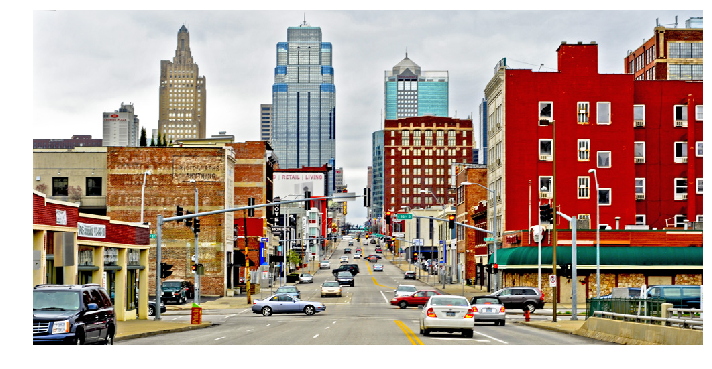

(500, 999, 3)


In [5]:
# display image
plot_single_image(image_raw)
print(image_raw.shape)

In [6]:
# preprocess image (basic cropping)
# image dimensions (GLOBAL) - [MG_WIDTH x IMG_HEIGHT, CHANNELS]
SQUARE_DIM = 450
if SQUARE_DIM:
    IMG_WIDTH = SQUARE_DIM
    IMG_HEIGHT = SQUARE_DIM
CHANNELS = 3

In [7]:
def quick_approx_crop(image, square_size):
    height, width, channels = image.shape
    xoff = (width - square_size) // 2
    yoff = (height - square_size) // 2
    # quick and dirty way to handle img that has odd dim size
    w_adj = 0
    h_adj = 0
    if width % 2 != 0:
        w_adj += 1
    if height % 2 != 0:
        h_adj += 1
    img_cropped = image[yoff+h_adj:-yoff,xoff+w_adj:-xoff]
    return img_cropped

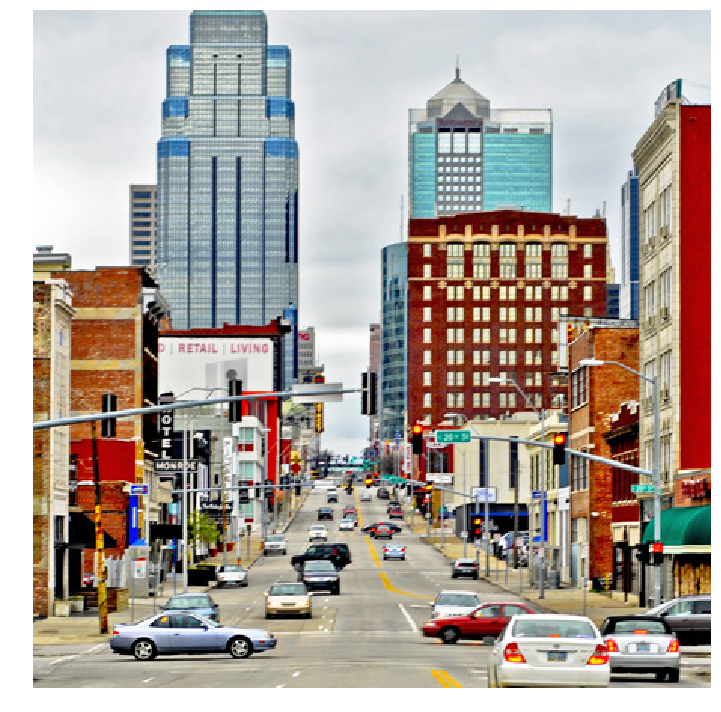

[215 219 218]
(450, 450, 3)


In [8]:
cropped_img = quick_approx_crop(image_raw, SQUARE_DIM)
plot_single_image(cropped_img)
print(cropped_img[200][200])
print(cropped_img.shape)

In [9]:
def stack_fmap_channels(fmap, channels):
    out_map = fmap.copy()
    for i in range(channels-1):
        out_map = np.dstack((out_map, fmap))
    return out_map

In [10]:
def concat_to_outputDim(fmap, channels):
    out_map = np.expand_dims(fmap, axis=3)
    fmap = np.expand_dims(fmap, axis=3)
    for i in range(channels-1):
        out_map = np.concatenate((out_map, fmap), axis=3)
    return out_map

In [11]:
def create_rgb_fmap_stack(fmap):
    outz = np.zeros([9,9,3,3])
    # create 9x9x3 for input dim
    # OUT: R
    # R
    outz[:,:,0,0] = fmap.copy()
    # G
    outz[:,:,1,0] = np.zeros([9,9])
    # B
    outz[:,:,2,0] = np.zeros([9,9])
    
    # OUT: G
    # R
    outz[:,:,0,1] = np.zeros([9,9])
    # G
    outz[:,:,1,1] = fmap.copy()
    # B
    outz[:,:,2,1] = np.zeros([9,9])
    
    # OUT: R
    # R
    outz[:,:,0,2] = np.zeros([9,9])
    # G
    outz[:,:,1,2] = np.zeros([9,9])
    # B
    outz[:,:,2,2] = fmap.copy()
    return outz

In [12]:
# create feature maps
v_line = np.asarray([[0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=np.float32)
# create NxNxin_channel
# v_line = stack_fmap_channels(v_line, CHANNELS)
# v_line = concat_to_outputDim(v_line, CHANNELS)
v_line = create_rgb_fmap_stack(v_line)

h_line = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)
# create NxNxin_channel
# h_line = stack_fmap_channels(h_line, CHANNELS)
# h_line = concat_to_outputDim(h_line, CHANNELS)
h_line = create_rgb_fmap_stack(h_line)

c_line = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 1, 1, 1, 0, 0, 0],
                     [0, 0, 0, 1, 1, 1, 0, 0, 0],
                     [0, 0, 0, 1, 1, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)
# create NxNxin_channel
# c_line = stack_fmap_channels(c_line, CHANNELS)
# c_line = concat_to_outputDim(c_line, CHANNELS)
c_line = create_rgb_fmap_stack(c_line)

[207 215 219]
(450, 450, 3)


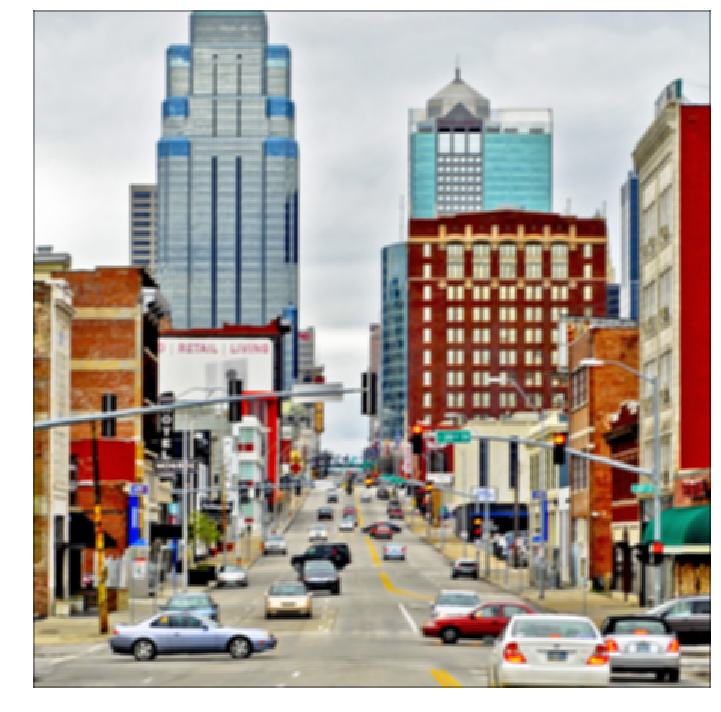

In [13]:
out = tf.nn.conv2d(input=np.expand_dims(cropped_img, axis=0).astype(np.float32), 
                   filter=c_line, strides=[1,1,1,1], padding="SAME")
outx = np.asarray(out)[0]

outz = np.zeros([450,450,3])
outz[:,:,0] = (outx[:,:,0] / np.max(outx[:,:,0]) + (np.min(outx[:,:,0])))*255
outz[:,:,1] = (outx[:,:,1] / np.max(outx[:,:,1]) + (np.min(outx[:,:,1])))*255
outz[:,:,2] = (outx[:,:,2] / np.max(outx[:,:,2]) + (np.min(outx[:,:,2])))*255

# print(np.max(outx[:,:,0]))
# print(np.max(outx[:,:,1]))
# print(np.max(outx[:,:,2]))

print(outz[100][230].astype(np.uint8))
print(outx.shape)
plot_single_image(outz)

2295.0
2295.0
[207 213 219]
(450, 450, 3)


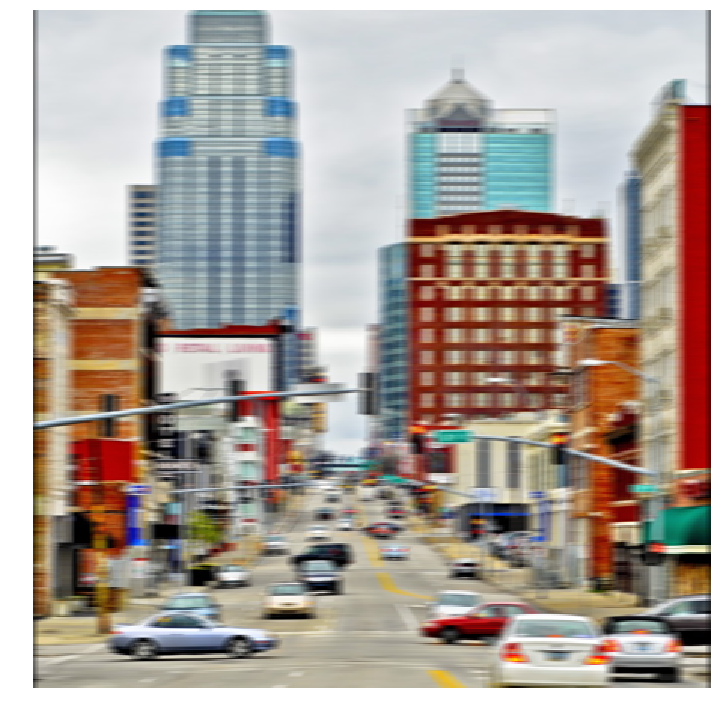

In [14]:
out = tf.nn.conv2d(input=np.expand_dims(cropped_img, axis=0).astype(np.float32), 
                   filter=h_line, strides=[1,1,1,1], padding="SAME")
outx = np.asarray(out)[0]

outz = np.zeros([450,450,3])
outz[:,:,0] = (outx[:,:,0] / np.max(outx[:,:,0]) + (np.min(outx[:,:,0])))*255
outz[:,:,1] = (outx[:,:,1] / np.max(outx[:,:,1]) + (np.min(outx[:,:,1])))*255
outz[:,:,2] = (outx[:,:,2] / np.max(outx[:,:,2]) + (np.min(outx[:,:,2])))*255

print(np.max(outx[:,:,1]))
print(np.max(outx[:,:,2]))

print(outz[100][230].astype(np.uint8))
print(outx.shape)
plot_single_image(outz)

(450, 450, 3)


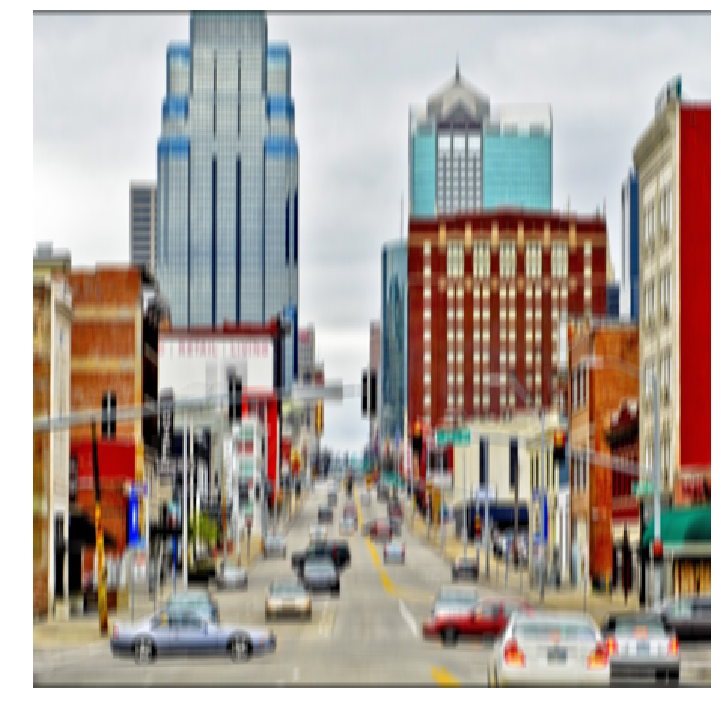

In [15]:
out = tf.nn.conv2d(input=np.expand_dims(cropped_img, axis=0).astype(np.float32), 
                   filter=v_line, strides=[1,1,1,1], padding="SAME")
outx = np.asarray(out)[0]
outz = np.zeros([450,450,3])
outz[:,:,0] = (outx[:,:,0] / np.max(outx[:,:,0]) + (np.min(outx[:,:,0])))*255
outz[:,:,1] = (outx[:,:,1] / np.max(outx[:,:,1]) + (np.min(outx[:,:,1])))*255
outz[:,:,2] = (outx[:,:,2] / np.max(outx[:,:,2]) + (np.min(outx[:,:,2])))*255
print(outx.shape)
plot_single_image(outz)